In [1]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear

from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

torch.backends.cudnn.benchmark = True

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = 'baseline_results/twoagents/'
experiment_id = 'compete_quantumcommunication_10x10/'

num_qubits =8
num_actions =4

row_num = 10
col_num = 10

cpu


In [3]:
Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cpu'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        
        return torch.Tensor(states).type(torch.float).to(device), torch.Tensor(actions).type(torch.long).to(device), torch.Tensor(next_states).to(device), torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)

In [4]:

def create_qnn():
    n_qubits = int(num_qubits/2)

    qc = QuantumCircuit(n_qubits)
    feature_map = ZFeatureMap(n_qubits)
    ansatz = RealAmplitudes(num_qubits=n_qubits, reps=1)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

def create_entanglement():
    n_qubits = int(num_qubits)

    qc = QuantumCircuit(n_qubits)
    feature_map = ZZFeatureMap(n_qubits)
    ansatz = EfficientSU2(num_qubits=n_qubits, reps=1)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

qnn_1 = create_qnn()
qnn_2 = create_qnn()

entanglement = create_entanglement()


print("QNN Training Parameters: ", qnn_1.num_weights)
print(qnn_1.circuit.draw('mpl'))

QNN Training Parameters:  8
Figure(705.552x367.889)


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_10713/2360708137.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_10713/2360708137.py:32: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


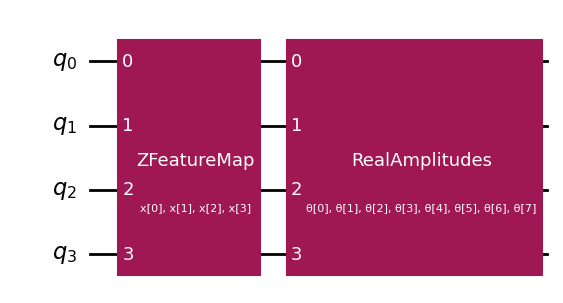

In [5]:
qnn_1.circuit.draw('mpl')

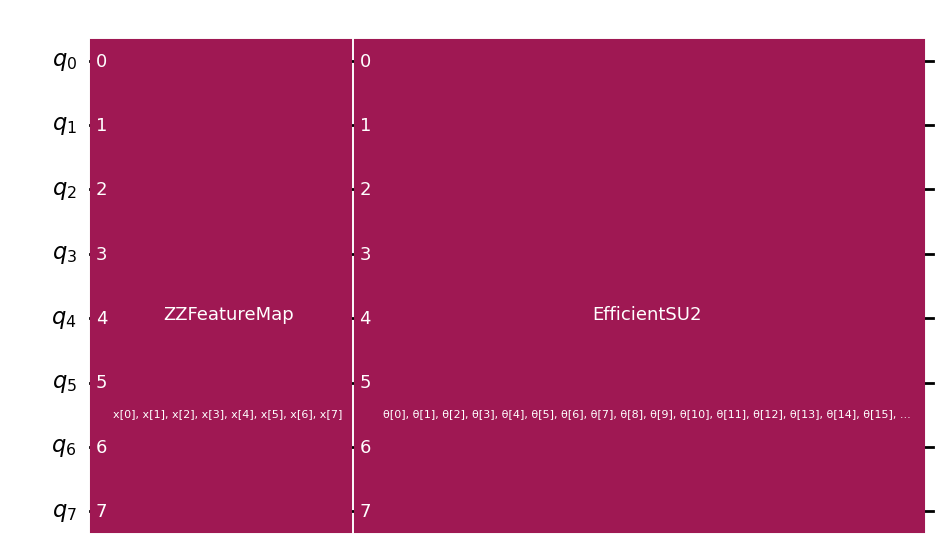

In [6]:
entanglement.circuit.draw('mpl')


In [7]:
class conv_nn(nn.Module):
    
    channels = [16, 32, 64]
    kernels = [3, 3, 3]
    strides = [1, 1, 1]
    in_channels = 1
    
    def __init__(self, rows, cols, n_act):
        super().__init__()
        self.rows = rows
        self.cols = cols

        self.conv_1 = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        
        self.conv_2 = nn.Sequential(nn.Conv2d(in_channels = self.in_channels,
                                            out_channels = self.channels[0],
                                            kernel_size = self.kernels[0],
                                            stride = self.strides[0]),
                                  nn.ReLU(),
                                  nn.Conv2d(in_channels = self.channels[0],
                                            out_channels = self.channels[1],
                                            kernel_size = self.kernels[1],
                                            stride = self.strides[1]),
                                  nn.ReLU()
                                 )
        


        

        self.linear_1 = nn.Sequential(nn.LazyLinear( num_qubits//2),
                                    TorchConnector(qnn_1),
                                    nn.LazyLinear(n_act),
                                   )
        
        self.linear_2 = nn.Sequential(nn.LazyLinear( num_qubits//2),
                                    TorchConnector(qnn_2),
                                    nn.LazyLinear(n_act),
                                   )
        
        self.linear_entanglement = nn.Sequential(nn.LazyLinear(n_act * 2),
                                             TorchConnector(entanglement),
                                             nn.LazyLinear(n_act * 2)
                                             )

        
        
        
    def forward(self, x1, x2):
    
        x1 = x1.view(len(x1), self.in_channels, self.rows, self.cols)
        out_conv_1 = self.conv_1(x1).view(len(x1),-1)

        out_lin_1 = self.linear_1(out_conv_1)

        x2 = x2.view(len(x2), self.in_channels, self.rows, self.cols)
        out_conv_2 = self.conv_2(x2).view(len(x2),-1)

        out_lin_2 = self.linear_2(out_conv_2)

        out_lin = torch.concat((out_lin_1, out_lin_2), dim=1)
        size_concat = out_lin.size()
        

        out_lin = self.linear_entanglement(out_lin)
        size_entangle = out_lin.size()
    
        
        if size_concat != size_entangle:
            print("_________ERROR_________")
            print("_________Pre entangle and Post entangle dont match_________")
        
        return out_lin

   

In [8]:
def get_qvalues(state_1, state_2, model):
    state_1 = torch.Tensor(state_1).to(device)
    state_2 = torch.Tensor(state_2).to(device)

    qvalues = model(state_1, state_2)


    qvalues_1, qvalues_2 = torch.split(qvalues, num_actions, dim=1)

    return qvalues_1, qvalues_2

In [9]:
def plot_policy_map(agent_1, agent_2, model, get_qvalues, filename, offset):

    with torch.no_grad():
        # Create two independent figures for the two agents
        fig1, ax1 = plt.subplots()
        fig2, ax2 = plt.subplots()
        
        ax1.imshow(agent_1.env.maze, cmap='Greys')
        ax2.imshow(agent_2.env.maze, cmap='Greys')

        for i in range(row_num):
            for j in range(col_num):
                free_cell = [i, j]

                if free_cell in agent_1.env.allowed_states or free_cell in agent_2.env.allowed_states:

                    agent_1.env.current_position = np.array(free_cell)
                    agent_2.env.current_position = np.array(free_cell)

                    state_1 = torch.Tensor(agent_1.env.state()).view(1, -1).to('cpu')
                    state_2 = torch.Tensor(agent_2.env.state()).view(1, -1).to('cpu')
                    

                    # Get Q-values for both agents
                    qvalues_1, qvalues_2 = get_qvalues(state_1, state_2, model)

                    
                    # Get best actions
                    if free_cell in agent_1.env.allowed_states:
                        action_1 = int(torch.argmax(qvalues_1).detach().cpu().numpy())
                        policy_1 = agent_1.env.directions[action_1]
                        ax1.text(free_cell[1] - offset[0], free_cell[0] - offset[1], policy_1)

                    if free_cell in agent_2.env.allowed_states:
                        action_2 = int(torch.argmax(qvalues_2).detach().cpu().numpy())
                        policy_2 = agent_2.env.directions[action_2]
                        ax2.text(free_cell[1] - offset[0], free_cell[0] - offset[1], policy_2)


                    
        # Cleanup axes
        for ax in [ax1, ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
        
       
        # Save figures separately
        
        fig1.savefig( directory + experiment_id +filename+"_agent1.png", dpi=300, bbox_inches='tight')
        fig2.savefig( directory + experiment_id +filename+"_agent2.png", dpi=300, bbox_inches='tight')

        # Show both figures
        plt.show()

In [10]:
def Qloss(batch1, batch2, model, gamma=0.99, device="cpu"):
    # Unpack the batch
    states_1, actions_1, next_states_1, rewards_1, _ = batch1
    states_2, actions_2, next_states_2, rewards_2, _ = batch2

    # Move data for both agents to the desired device
    states_1 = states_1.to(device)
    actions_1 = actions_1.to(device)
    next_states_1 = next_states_1.to(device)
    rewards_1 = rewards_1.to(device)

    states_2 = states_2.to(device)
    actions_2 = actions_2.to(device)
    next_states_2 = next_states_2.to(device)
    rewards_2 = rewards_2.to(device)
    
    # Convert states and next_states to NumPy arrays
    states_1 = states_1.cpu().detach().numpy()
    next_states_1 = next_states_1.cpu().detach().numpy()

    states_2 = states_2.cpu().detach().numpy()
    next_states_2 = next_states_2.cpu().detach().numpy()
    

    # Create PyTorch tensors from the NumPy arrays
    states_tensor_1 = torch.from_numpy(states_1).to(device)
    next_states_tensor_1 = torch.from_numpy(next_states_1).to(device)

    states_tensor_2 = torch.from_numpy(states_2).to(device)
    next_states_tensor_2 = torch.from_numpy(next_states_2).to(device)

    # Get the number of samples in the batch
    lbatch = len(states_tensor_1)
    lbatch2 = len(states_tensor_2)

    if lbatch != lbatch2:
        print("_________ERROR_________")
        print("_________BATCH SIZE_________")

    # Get the Q-values for the current states
    qvalues_1, qvalues_2 = get_qvalues(states_tensor_1.view(lbatch,-1), states_tensor_2.view(lbatch,-1), model)

    qvalues_1 = qvalues_1.gather(1, actions_1.unsqueeze(-1))
    qvalues_1 = qvalues_1.squeeze(-1)

    qvalues_2 = qvalues_2.gather(1, actions_2.unsqueeze(-1))
    qvalues_2 = qvalues_2.squeeze(-1)


    # Get the Q-values for the next states
    next_qvalues_1, next_qvalues_2 = get_qvalues(next_states_tensor_1.view(lbatch, -1), next_states_tensor_2.view(lbatch, -1), model)

    next_qvalues_1 = next_qvalues_1.max(1)[0]
    next_qvalues_1 = next_qvalues_1.detach()

    next_qvalues_2 = next_qvalues_2.max(1)[0]
    next_qvalues_2 = next_qvalues_2.detach()

    # Compute the expected Q-values
    expected_state_action_values_1 = next_qvalues_1 * gamma + rewards_1 
    expected_state_action_values_2 = next_qvalues_2 * gamma + rewards_2\
    
    combined_values= torch.concat((qvalues_1, qvalues_2), dim=0)
    combined_next_values = torch.concat((expected_state_action_values_1, expected_state_action_values_2), dim= 0)

    len_combine = combined_values.size()
    len_next = combined_next_values.size()
    if len_combine != len_next:
        print("_________ERROR_________")
        print("_________COMBINED BATCH_________")


    return nn.MSELoss()(combined_values, combined_next_values)
    

In [11]:
from environment import MazeEnvironment

maze = np.load('./maze_generator/maze_' + str(row_num) + 'x' + str(col_num) + '.npy')

start_position =[0,0]
end_position = [len(maze)-1, len(maze)-1]

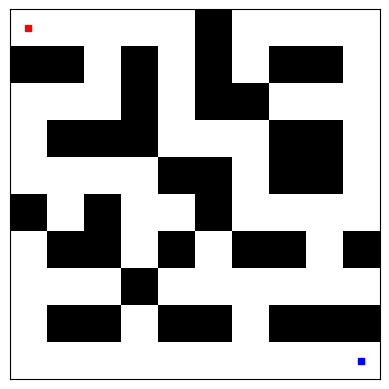

In [12]:
maze_env_1 = MazeEnvironment(maze, start_position, end_position)
maze_env_1.draw(directory + 'maze.png')

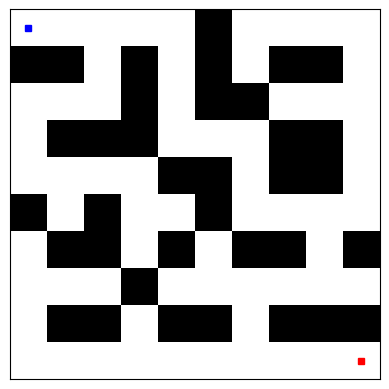

In [13]:
maze_env_2 = MazeEnvironment(maze, end_position, start_position)
maze_env_2.draw(directory + 'maze.png')

In [14]:
buffer_capacity = 10000
buffer_size = 1000

memory_buffer_1 = ExperienceReplay(buffer_capacity)
memory_buffer_2 = ExperienceReplay(buffer_capacity)

In [15]:
from agent import Agent


agent_1 = Agent(maze = maze_env_1,
              memory_buffer = memory_buffer_1,
              use_softmax = True
             )

agent_2 = Agent(maze = maze_env_2,
              memory_buffer = memory_buffer_2,
              use_softmax = True
             )


In [16]:
net = conv_nn(row_num, col_num, 4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

batch_size = 24
gamma = 0.9
net.to(device)


conv_nn(
  (conv_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (conv_2): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
  )
  (linear_1): Sequential(
    (0): LazyLinear(in_features=0, out_features=4, bias=True)
    (1): TorchConnector()
    (2): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (linear_2): Sequential(
    (0): LazyLinear(in_features=0, out_features=4, bias=True)
    (1): TorchConnector()
    (2): LazyLinear(in_features=0, out_features=4, bias=True)
  )
  (linear_entanglement): Sequential(
    (0): LazyLinear(in_features=0, out_features=8, bias=True)
    (1): TorchConnector()
    (2): LazyLinear(in_features=0, out_features=8, bias=True)
  )
)

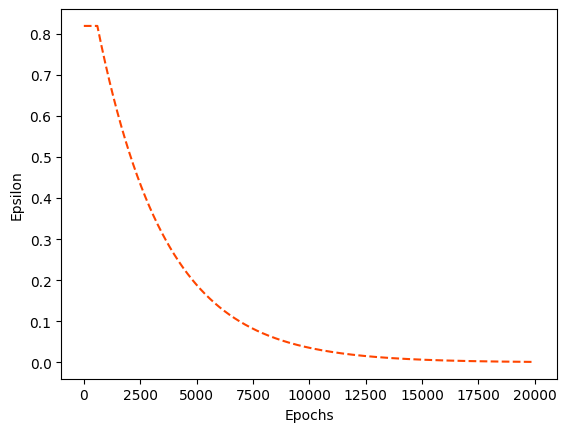

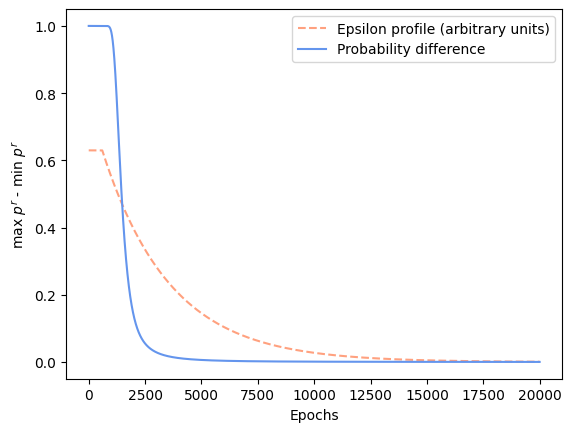

In [17]:
num_epochs = 20000

cutoff = 3000
epsilon = np.exp(-np.arange(num_epochs)/(cutoff))
epsilon[epsilon > epsilon[100*int(num_epochs/cutoff)]] = epsilon[100*int(num_epochs/cutoff)]
plt.plot(epsilon, color = 'orangered', ls = '--')
plt.xlabel('Epochs')
plt.ylabel('Epsilon')
plt.savefig('epsilon_profile.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()

mp = []
mpm = []
reg = 200
for e in epsilon:
    a = agent_1.env.reset_policy(e)
    mp.append(np.min(a))
    mpm.append(np.max(a))

plt.plot(epsilon/1.3, color = 'orangered', ls = '--', alpha = 0.5,
         label= 'Epsilon profile (arbitrary units)')

plt.plot(np.array(mpm)-np.array(mp), label = 'Probability difference', color = 'cornflowerblue')
plt.xlabel('Epochs')
plt.ylabel(r'max $p^r$ - min $p^r$')
plt.legend()
plt.savefig(directory +'reset_policy.pdf', dpi = 300, bbox_inches = 'tight')
plt.show()


In [18]:
def contains(list, object):
    for item in list:
        if (item == object).all():
            return True
    
    return False
def equal(a, b):
    if len(a) != len(b):
        print("Lengths are not equal")
        print("Length of a: ", len(a))
        print("Length of b: ", len(b))
    
        return False
    for i in range(len(a)):
        if a[i] != b[i]:
            return False
    return True

In [19]:
def plot_loss(loss):
    plt.plot(loss,  label = 'Loss', color = 'deepskyblue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(directory + experiment_id + 'loss.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

def plot_reward(reward_1, reward_2):
    plt.plot(reward_1,  label = 'Agent 1', color = 'orangered')
    plt.plot(reward_2,  label = 'Agent 2', color = 'deepskyblue')
    plt.xlabel('Epochs')
    plt.ylabel('Reward')
    plt.savefig(directory + experiment_id + 'reward.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

def plot_winrate(winrate_total, winrate_1, winrate_2):
    plt.plot(winrate_total, label = 'Combined Wins', color = 'deepskyblue')
    plt.plot(winrate_1, label = 'Agent 1 ', color = 'deepskyblue')
    plt.plot(winrate_2, label = 'Agent 2', color = 'deepskyblue')
    plt.xlabel('Epochs')
    plt.ylabel('Win Rate')
    plt.legend()
    plt.savefig(directory + experiment_id + 'winrate.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()

In [20]:
def update(agent, action):
    is_game_on = True

    # Initialize reward, each move costs 0.05
    reward = -.05

    move = agent.env.action_map[action]
    next_position = agent.env.current_position + np.asarray(move)

    if (agent.env.current_position == agent.env.goal).all():
        is_game_on = False
        reward = 1

        return (agent.env.state(), reward, is_game_on)
    else:
        if tuple(agent.env.current_position) in agent.env.visited:
            reward = -0.2

    if agent.env.is_state_valid(next_position):
        agent.env.current_position = next_position
    else:
        reward = -1
    agent.env.visited.add(tuple(agent.env.current_position))

    return (agent.env.state(), reward, is_game_on)


    

In [21]:
def state_update(action1, action2):
    agent_1_update = update(agent_1, action1)
    agent_2_update = update(agent_2, action2)
    return agent_1_update, agent_2_update

In [22]:
def get_reward():
    agent_1.env.current_position = np.asarray(start_position)
    agent_2.env.current_position = np.asarray(end_position)

    counter = 0

    reward1 = 0
    reward2 =0
    
    while counter < 100:
        
        # Get the current state
        state1 = torch.tensor(agent_1.env.state()).view(1,-1).float()
        state2 = torch.tensor(agent_2.env.state()).view(1,-1).float()

        # Get the Q-values
        qvalues1, qvalues2 = get_qvalues(state1, state2, net)
        
        if not equal(agent_1.env.current_position, agent_1.env.goal):
            action1 = max(0, int(torch.argmax(qvalues1).detach().cpu().numpy()))
            update1 = update(agent_1,action1)
            reward1 += update1[1]
        if not equal(agent_2.env.current_position, agent_2.env.goal):
            action2 = max(0, int(torch.argmax(qvalues2).detach().cpu().numpy()))
            update2 = update(agent_2,action2)
            reward2 += update2[1]

        counter += 1
 
    return reward1, reward2

    

In [ ]:
loss_log = []

reward_log_1 = []
reward_log_2 = []

best_loss = 100000
best_reward_1, best_reward_2 = -101, -101


running_loss = 0

win_counter_1 = 0
win_counter_2 = 0
win_counter = 0

win_total_log = []
win_1= []
win_2 = []

estop = 0



for epoch in range(num_epochs):
    loss = 0
    counter = 0

    eps = epsilon[epoch]

    agent_1.isgameon = True
    agent_1.env.reset(eps)

    agent_2.isgameon = True
    agent_2.env.reset(eps)

    while agent_1.isgameon and agent_2.isgameon:
        # Get the current state
        current_state_1 = agent_1.env.state()
        state_1 = torch.tensor(current_state_1).view(1,-1).float()

        current_state_2 = agent_2.env.state()
        state_2 = torch.tensor(current_state_2).view(1,-1).float()

        # Get the Q-values for the current state
        qvalues_1, qvalues_2 = get_qvalues(state_1, state_2, net)

        # Select an action
        action_1 = agent_1.select_action(qvalues_1, eps, device= device)
        action_2 = agent_2.select_action(qvalues_2, eps, device= device)

        # Update the state
        update_1, update_2 = state_update(action_1, action_2)

        # Store the transition
        agent_1.make_a_move(qvalues_1, eps, update_1, action_1, current_state_1)
        agent_2.make_a_move(qvalues_2, eps, update_2, action_1, current_state_1)

        if len(agent_1.buffer) < buffer_size and len(agent_2.buffer)<buffer_size:
            continue
        
        # Sample a batch of transitions
        optimizer.zero_grad()
        batch_1 = agent_1.buffer.sample(batch_size, device= device)
        batch_2 = agent_2.buffer.sample(batch_size, device= device)

        # Compute the loss
        loss_t = Qloss(batch_1, batch_2, net,gamma= gamma, device =device)

        # Backpropagate the loss
        loss_t.backward()
        optimizer.step()

        # Update the running loss
        loss += loss_t.item()
        counter += 1

    loss_log.append(loss)

    if epoch > 2000:
        running_loss = np.mean(loss_log[-50:])
        if running_loss < best_loss :
            best_loss = running_loss
            torch.save(net.state_dict(), directory + experiment_id + 'model_best_loss.pth')
            estop = epoch
 
    result = 'Lost'
    if (agent_1.env.current_position == agent_1.env.goal).all() and (agent_2.env.current_position == agent_2.env.goal).all():
        win_counter += 1
        win_counter_1 +=1
        win_counter_2 +=1
        result = 'Both Agents Win'
    elif (agent_1.env.current_position == agent_1.env.goal).all():
        win_counter += 1
        win_counter_1 +=1
        result = 'Agent 1 Wins'
    elif (agent_2.env.current_position == agent_2.env.goal).all():
        win_counter += 1
        win_counter_2 +=1
        result = 'Agent 2 Wins'
    
    win_total_log.append(win_counter/(epoch + 1))
    win_1.append(win_counter_1/(epoch + 1))
    win_2.append(win_counter_2/(epoch + 1))

    filename = 'sol_epoch_' + str(epoch)

    if epoch % 100 == 0:
        reward_1, reward_2= get_reward()
        reward_log_1.append(reward_1)
        reward_log_2.append(reward_2)
        if reward_1 >= best_reward_1:
            torch.save(net.state_dict(), directory + experiment_id + 'best_model_reward_1.pth')
        if reward_2 >= best_reward_2:
            torch.save(net.state_dict(), directory + experiment_id + 'best_model_reward_2.pth')


    if(epoch % 100 == 0 and epoch <= 5000) or (epoch % 500 == 0):
        plot_policy_map(agent_1, agent_2, net, get_qvalues, filename, offset = [0.35, -0.3])
        plot_loss(loss_log)
        plot_reward(reward_log_1, reward_log_2)
        plot_winrate(win_total_log, win_1, win_2)

    clear_output(wait=True)
    print('Epoch', epoch, '(number of moves ' + str(counter) + ')')
    print('Game', result)

    print('[' + '#'*(100-int(100*(1 - epoch/num_epochs))) +
          ' '*int(100*(1 - epoch/num_epochs)) + ']')
    print('\t Average loss: ' + f'{loss:.5f}')
    if (epoch > 2000):
        print('\t Best average loss of the last 50 epochs: ' + f'{best_loss:.5f}' + ', achieved at epoch', estop )
    




Epoch 141 (number of moves 4)
Game Agent 2 Wins
[#                                                                                                   ]
	 Average loss: 1.94273
